In [2]:
import cv2
import argparse
from model.build_BiSeNet import BiSeNet
import os
import torch
import cv2
from imgaug import augmenters as iaa
from PIL import Image
from torchvision import transforms
import numpy as np
from utils import reverse_one_hot, get_label_info, colour_code_segmentation



In [20]:
def predict_on_image(model, f, args):
    # pre-processing on image
    # Carregue a imagem TIFF com Pillow
    image = Image.open(args.data)
    image = np.array(image)  # Converte para um array NumPy
    
    # Verifique se é uma imagem em grayscale ou colorida
    if len(image.shape) == 2:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 4:  # Caso a imagem tenha um canal alpha
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    
    # Redimensione a imagem conforme necessário
    resize = iaa.Scale({'height': args.crop_height, 'width': args.crop_width})
    resize_det = resize.to_deterministic()
    image = resize_det.augment_image(image)
    image = Image.fromarray(image).convert('RGB')
    image = transforms.ToTensor()(image)
    image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image).unsqueeze(0)
    # read csv label path
    label_info = get_label_info(args.csv_path)
    # predict
    model.eval()
    predict = model(image).squeeze()
    predict = reverse_one_hot(predict.cpu())
    predict = colour_code_segmentation(np.array(predict), label_info)
    predict = cv2.resize(np.uint8(predict), (1024, 1024))
    cv2.imwrite( os.path.join(args.save_path,f), cv2.cvtColor(np.uint8(predict), cv2.COLOR_RGB2BGR))



In [21]:
def experiment(params):
    # basic parameters
    parser = argparse.ArgumentParser()
    parser.add_argument('--image', action='store_true', default=False, help='predict on image')
    parser.add_argument('--video', action='store_true', default=False, help='predict on video')
    parser.add_argument('--checkpoint_path', type=str, default=None, help='The path to the pretrained weights of model')
    parser.add_argument('--context_path', type=str, default="resnet101", help='The context path model you are using.')
    parser.add_argument('--num_classes', type=int, default=10, help='num of object classes (with void)')
    parser.add_argument('--data', type=str, default=None, help='Path to image or video for prediction')
    parser.add_argument('--crop_height', type=int, default=1024, help='Height of cropped/resized input image to network')
    parser.add_argument('--crop_width', type=int, default=1024, help='Width of cropped/resized input image to network')
    parser.add_argument('--cuda', type=str, default='0', help='GPU ids used for training')
    parser.add_argument('--use_gpu', type=bool, default=True, help='Whether to user gpu for training')
    parser.add_argument('--csv_path', type=str, default=None, required=True, help='Path to label info csv file')
    parser.add_argument('--save_path', type=str, default=None, required=True, help='Path to save predict image')


    args = parser.parse_args(params)

    # build model
    os.environ['CUDA_VISIBLE_DEVICES'] = args.cuda
    model = BiSeNet(args.num_classes, args.context_path)
    if torch.cuda.is_available() and args.use_gpu:
        model = torch.nn.DataParallel(model).cuda()

    # load pretrained model if exists
    print('load model from %s ...' % args.checkpoint_path)
    model.module.load_state_dict(torch.load(args.checkpoint_path))
    print('Done!')

    # predict on image
    if args.image:
        files = os.listdir(args.data)
        buffer = args.data
        for f in files:
            args.data = os.path.join( buffer,f)
            predict_on_image(model, f, args)

    # predict on video
    if args.video:
        pass



In [23]:
if __name__ == '__main__':
    params = [
        '--image',
        '--data', 'dataset/test',
        '--checkpoint_path', 'checkpoints_18_sgd/best_dice_loss.pth',
        '--cuda', '0',
        '--csv_path', 'dataset/class_dict.csv',
        '--save_path', 'predicted/',
        '--context_path', 'resnet18'
    ]
    experiment(params)

load model from checkpoints_18_sgd/best_dice_loss.pth ...
Done!


In [ ]:
# Resize image to half its size
import rasterio

#files = os.listdir(args.data)
# Path to the folder containing the images
image = 'dataset/test/14336_6144.tiff'
GT_mask = 'test/14336_6144.tiff'
t_mask = 'test/14336_6144.tiff'


with rasterio.open(image) as src:
    profile = src.profile
    profile.update(width=int(src.width / 2), height=int(src.height / 2))

    with rasterio.open(image, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            dst.write(src.read(i), indexes=i)

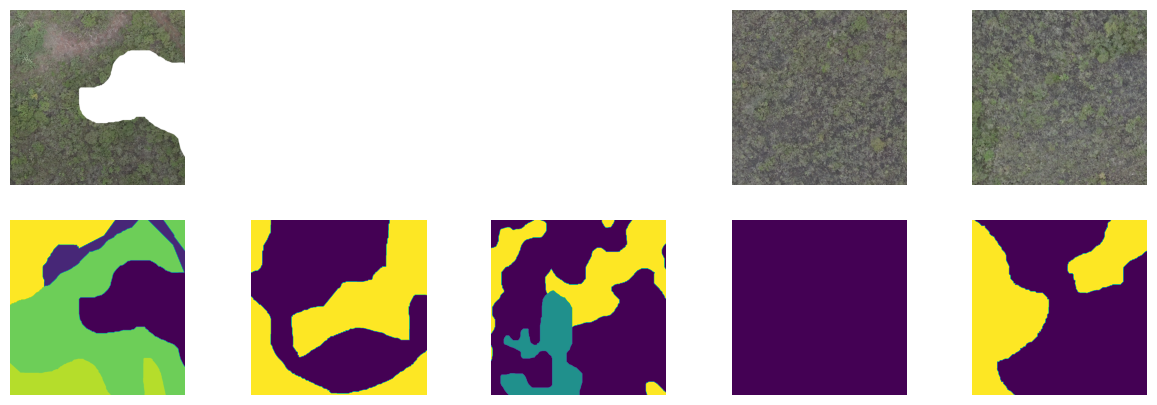

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# Função para carregar e abrir as imagens TIFF
def open_images(image_paths, src):
    images = [Image.open(os.path.join(src, path)) for path in image_paths]
    masks =  [Image.open(os.path.join(src+'_label', path)) for path in image_paths]
    return images, masks

# Função para exibir as imagens lado a lado
def display_images_side_by_side(images,masks):
    # Defina o número de imagens a serem exibidas (3 neste caso)
    amostra = [(images[i] , masks[i]) for i in range(5)]
    num_images = len(amostra)
    
    
    
    # Crie uma figura e eixos no Matplotlib
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    # Se for uma imagem, mantenha axes como uma lista
    if num_images == 1:
        axes = [axes]
    
    # Loop para mostrar cada imagem em um eixo
    for i, img in enumerate(amostra):
            axes[0][i].imshow(img[0])
            axes[0][i].axis('off')  # Remova os eixos
            axes[1][i].imshow(img[1])
            axes[1][i].axis('off')


    # Mostre as imagens
    plt.show()

# Caminhos para os arquivos de imagem TIFF
src = 'dataset/test'
files = os.listdir(src)


# Carregar as imagens
images, masks = open_images(files, src)

# Exibir as imagens lado a lado
display_images_side_by_side(images, masks)